In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector


import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import pandas as pd 
import numpy as np
import warnings

import jupyter_beeper as beeper

warnings.filterwarnings("ignore")

### Load and inspect the data to get a view of the columns and its contents

In [3]:
car_data = pd.read_csv('vehicles.csv')
car_data.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
81067,7314471763,pueblo,8999,2013.0,honda,civic,excellent,NaN,gas,158208.0,clean,automatic,19XFB2E5XDE020192,fwd,NaN,sedan,NaN,co
385835,7310717182,provo / orem,10950,2018.0,toyota,corolla le,NaN,4 cylinders,gas,77312.0,rebuilt,automatic,NaN,fwd,NaN,sedan,red,ut
403175,7313541388,kennewick-pasco-richland,56725,2018.0,ram,cummins 2500 4x4 auto,NaN,NaN,diesel,16486.0,clean,automatic,3C6UR5CLXJG328900,4wd,NaN,truck,white,wa
382494,7311216619,san antonio,13999,2012.0,toyota,tacoma prerunner,like new,6 cylinders,gas,212800.0,clean,automatic,5TFJU4GN8CX026729,NaN,NaN,truck,silver,tx
342803,7310434971,rhode island,22990,2017.0,volkswagen,golf gti sport,good,NaN,gas,30334.0,clean,other,3VW447AU6HM003541,fwd,NaN,sedan,white,ri


In [4]:
# Look at the column contents to understand data types and completeness. 
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

---
As seen above, not all the data is fully populated, that means empty or null values along with the different data types, we can see that they are not all numeric.  Based on this data we will look at individual columns to inspect their contents and define the data preparation steps

In [5]:
# Inspect the data to understand how many unique/different values exist per category.   
# Specifically the non-numeric columns are important to understand as we will need to somehow apply a transformer to represent them as a number for our model later on
car_data.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

Let's look at columns that could be eliminated - columns that we think do not provide influence on the price of the car, like the `VIN` and `id`. 
Note that there is also 404 different regions this is a very high number and if encoded you would then add 404 columns to the dataset, making it very heavy
to compute.   One of the key objectives of data preparation, other than enable compute is to simplify the dataset to a reasonable level in order to allow 
compute with reasonable resources.  In this case the compute will occur on a traditional PC, not a dedicated datacenter with AI accelerators, so we will try to simplify 
the dataset to be practical with some compromises, the first one will be to eliminate the `region` column.  We will lose that as a factor for the analysis, but it is done
in purpose in order to be practical.  As of this point we still have the `state` category that also provides somehow this information although with less granularity.

In [6]:
# Eliminate columns as described above
car_data.drop('VIN', axis=1, inplace=True)
car_data.drop('id', axis=1, inplace=True)
car_data.drop('region', axis=1, inplace=True)

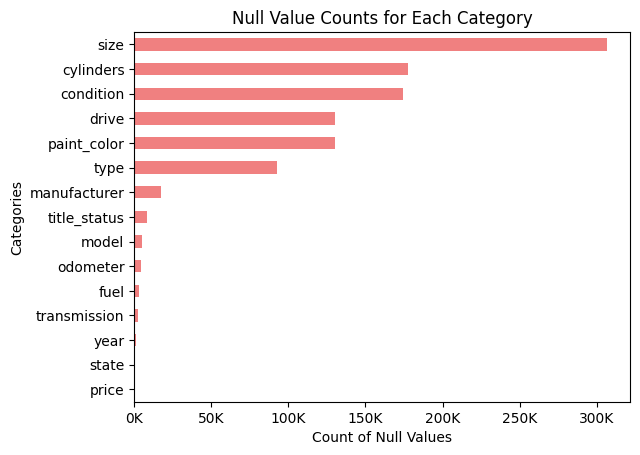

In [7]:
# Count non-null values in each column and plot to compare

def format_thousands(x, pos):
    return f'{int(x/1000)}K'

fig, ax = plt.subplots()

# Plotting a horizontal bar chart with formatting
car_data.isnull().sum().sort_values().plot(kind='barh', color='lightcoral', ax=ax)

# ax = car_data.count().sort_values().plot(kind='barh', color='lightcoral')
ax.xaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.title('Null Value Counts for Each Category')
plt.ylabel('Categories')
plt.xlabel('Count of Null Values')
plt.show()

As seen above there are some categories that are missing significant amount of data: `size`, `cylinders`, `condition`, `drive` and others as seen in the chart above, these categories are fundamental for a car, so we will apply the following logic:

1. For the categories that have a very little amount of missing values, we will simply remove those entries for the dataset, this will be less than 5% of the volume, so we are not expecting any major impact in the model.  That will be the categories at the bottom of the chart above

2. Fill the missing data with `unknown` as an indication of a realistic situation, when a car is being offered online or in a way that can't be seen, also some categories like the color of if it is electric, it can be confusing to define a drive type or cylinders, so the data somehow is taken that way.  We could use that information into our model and see ho wmuch of an impact will have eventually. 

In [8]:
# Specify a list of columns to remove rows with NaN values - as described in #1 above
columns_to_check = ['year', 'transmission', 'manufacturer', 'odometer', 'model']
car_data.dropna(subset=columns_to_check, inplace=True)

# Now applying #2 from above, replace all the NaNs with 'unknown'  - note that there are now, no columns with any NaNs
car_data.fillna('unknown', inplace=True)
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398275 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         398275 non-null  int64  
 1   year          398275 non-null  float64
 2   manufacturer  398275 non-null  object 
 3   model         398275 non-null  object 
 4   condition     398275 non-null  object 
 5   cylinders     398275 non-null  object 
 6   fuel          398275 non-null  object 
 7   odometer      398275 non-null  float64
 8   title_status  398275 non-null  object 
 9   transmission  398275 non-null  object 
 10  drive         398275 non-null  object 
 11  size          398275 non-null  object 
 12  type          398275 non-null  object 
 13  paint_color   398275 non-null  object 
 14  state         398275 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.6+ MB


### Understanding cardinality and transformation/encoding
Now let's look at the cardinality of the data (number of unique values in a dataset or a particular column within a dataset) this will give us an idea of how many categories we will have in our model after we apply transformations in order to convert categorical data into numeric representation so a mathematical model can be built.  As seen below from the non-numeric columns this is a high cardinality dataset as some categories have a high number of unique values, such as `model`

In [9]:
# Count unique values excluding numeric columns?
unique_value_counts = car_data.select_dtypes(exclude=['number']).nunique()
print(unique_value_counts)
print('\nTotal of potential columns if using a OneHotEncoder: ', unique_value_counts.sum())

manufacturer       41
model           23499
condition           7
cylinders           9
fuel                6
title_status        7
transmission        3
drive               4
size                5
type               14
paint_color        13
state              51
dtype: int64

Total of potential columns if using a OneHotEncoder:  23659


As noted above, the `model` category has an extremely high cardinality.  And it is a column that we would have to apply a OneHotEncoder as it is a categorical feature with no correlation between values.  Just alone this category will add a whopping 23499 columns to the dataset which will be a massive load for computing the model later on. 
I did some analysis to group those values and maybe only take the top 100 values.   As seen below:

In [10]:
# Use value_counts() to count occurrences of each value in 'your_column'
value_counts = car_data['model'].value_counts()

# Select the top 100 values
top = 100 
top_values = value_counts.head(top)

print("Top", top, "values")
print(top_values)
print(top_values.sum())

Top 100 values
model
f-150                     7835
silverado 1500            5038
1500                      4158
camry                     3064
silverado                 2946
                          ... 
silverado 1500 regular     614
frontier                   604
cts                        592
328i                       578
x3                         570
Name: count, Length: 100, dtype: int64
141355


The information seems to be heavily fragmented.  So it is not obvious to apply a "paretto-like" approach here.   Also the other option is to group values 
using Jaccard similarity algorithms such as fuzzywuzzy, Jellyfish or pariwise distances. Example: Camry SL and Camry GS as 'Camry', with that, it would be reduced from 20k+ to 1.1k, which is still too
many columns.  This is something that could be finetuned as a recommendation to improve the model.  To reduce it even further you could have a more aggressive string similarity match algorithm, 
with a lower threshold, but at that point you are still at 500+ columns and the loss of information is significant for example 'Jeep' vs. 'Jeep Cherokee' vs. 'Jeep Gladiator' which are VERY different 
vehicles, would appear as the same. I made the decision to ignore this column and go with the 'manufacturer' instead as an indicator that only has 29 unique values. 

In [11]:
# Count unique values excluding numeric columns?
unique_value_counts = car_data.select_dtypes(exclude=['number']).nunique()
print(unique_value_counts)
print('\nTotal of potential columns after encoding: ', unique_value_counts.sum())

manufacturer       41
model           23499
condition           7
cylinders           9
fuel                6
title_status        7
transmission        3
drive               4
size                5
type               14
paint_color        13
state              51
dtype: int64

Total of potential columns after encoding:  23659


Now let's look at the meaning of the categories applying some domain knowledge and see what is the best way to encode them, so they can be numeric. The categorical features with no relation between each other will use a one hot encoder and the categories that have information that follows a relationship or a quantified value could be transformed using an ordinal encoder.   Summarizing:

One Hot Encoding:
* Manufacturer, cylinders, fuel, transmission, drive, size, type, paint color and state

Ordinal Encoding:
* Condition, Title Status

Keep in mind that ordinal encoding provides a way to quantify the variables, for example a 'clean' title is better than a 'salvage' title or a condition='excellent' is better than condition='fair, so we apply ordinal encoding.  For other cases such as read color or blue color, it is subjective so one is not necessarily better or scored higher than the other. 

Applying that logic we are still above 100+ columns which will make a very heavy dataset for compute.   So we will intentionally remove more columns in order to simplify the dataseet further, this will bring unknown innaccuracy for the model at the end, but given the resource constraints that we have we will proceed in order to reduce the number of columns further.   See the code noting the removal of additional columns that I think will have less impact on price vs. others. 


In [12]:
car_data.drop('paint_color', axis=1, inplace=True)
car_data.drop('size', axis=1, inplace=True)
car_data.drop('cylinders', axis=1, inplace=True)
car_data.drop('state', axis=1, inplace=True)
car_data.drop('model', axis=1, inplace=True)

In [13]:
unique_value_counts = car_data.select_dtypes(exclude=['number']).nunique()
print(unique_value_counts)
print('\nTotal of potential columns after encoding: ', unique_value_counts.sum())

manufacturer    41
condition        7
fuel             6
title_status     7
transmission     3
drive            4
type            14
dtype: int64

Total of potential columns after encoding:  82


As seen above, we are now down to 82 columns or less (given the mix of ordinal and onehot encoding) and a total dataset of 315k+ entries, all filled and complete across columns. We will know the exact number after we apply the encoders.

In [14]:
# Now we will deal with outliers, related to prices that are not meaningful.  Exclude very high price (exotic) and cars that are worth less than $500 

# Specify the price range
min_price = 500
max_price = 300000

# Use boolean indexing to filter the DataFrame
car_data = car_data[(car_data['price'] >= min_price) & (car_data['price'] <= max_price)]

# Reset/rebuild the index as it is referencing the original dataset that has now been heavily filtered.  The original index numbers don't mean anything anymore
car_data.reset_index(drop=True, inplace=True)

In [15]:
# now, apply one hot encoder and ordinal encoders for categorical data as mentioned above

one_hot_encoder_columns = ['manufacturer', 'fuel', 'transmission', 'drive', 'type']
ordinal_encoder_columns = ['condition', 'title_status']

# Criteria used for ordinal encoding:

# title_status
# 0 missing
# 1 unknown
# 2 parts only
# 3 salvage
# 4 rebuilt
# 5 lien
# 6 clean

# condition
# 0 unknown
# 1 salvage
# 2 fair
# 3 good
# 4 excellent
# 5 like new
# 6 new

pref_order_condition = ['unknown', 'salvage', 'fair', 'good', 'excellent', 'like new', 'new']
pref_order_title_status = [ 'missing', 'unknown', 'parts only', 'salvage', 'rebuilt', 'lien', 'clean']

# Initialize the OrdinalEncoder objects with the preferred order
condition_encoder = OrdinalEncoder(categories=[pref_order_condition])
title_status_encoder = OrdinalEncoder(categories=[pref_order_title_status])

# Fit and transform the DataFrame using the fit_transform method
car_data['Encoded_condition'] = condition_encoder.fit_transform(car_data[['condition']])
car_data['Encoded_title_status'] = title_status_encoder.fit_transform(car_data[['title_status']])

# Drop original columns
car_data = car_data.drop('condition', axis=1)
car_data = car_data.drop('title_status', axis=1)

# # Apply one-hot encoding using pandas get_dummies  (we will use a new variable to denote the 'encoded' version of the dataset
car_data_e = pd.get_dummies(car_data, columns=one_hot_encoder_columns)

In [16]:
car_data_e.sample(3)

,price,year,odometer,Encoded_condition,Encoded_title_status,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,...,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_unknown,type_van,type_wagon
15107,6000,2000.0,97000.0,3.0,6.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
254747,25590,2017.0,30509.0,0.0,6.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
187714,4895,2003.0,197000.0,0.0,6.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Modeling

As seen above, we are now down to 73 columns after applying transfomation encoding and making some compromises to reduce the number of categories.  The dataset is now filled consistently with numeric only data.   The data preparation phase is completed, so we will proceed to the modeling stage. 

We will use simple cross validation, spliting the dataset in train and test datasets in order to check with real unseen data, how effective the model is and also to check for overfitting

In [17]:
# Define training and output variables
X = car_data_e.drop('price', axis = 1) # Remove the price column, the target variable
y = car_data_e['price']                # Set the output variable

In [18]:
# Split into train and test data sets for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77)

#### Trying different models and measuring error

Now we will attempt to use different models with different transformers and measure the error against the training and test datasets.   It will tells about overfitting and also how accurate the model is when compared with the test data that was unseen during the training process.   I will use pipelines in order to facilitate all the combinations.

#### Selecting the error metric

In this case we want to select an error metric that adapts more to the practical application, the choice between Mean Absolute Error (MAE) and Mean Squared Error (MSE) depends on the specific characteristics of the data and the goals of the analysis. 

I chose to use mean average error (MAE) due to the following reasons:

* Sensitivity to Outliers:  Minimize their impact on the performance metric, less sensitive to outliers than MSE because it doesn't square the errors.
* Scale of the Error: MSE gives more weight to larger errors due to the squaring operation. The scale of the error is crucial in this context, as i want to represent accurately the potential difference on the price of a car on vs. its predicted price where the actual amount can be interpreted directly
* Model Sensitivity: MSE tends to penalize large errors more heavily than MAE, tolerable errors may still be in the thousands of dollars, so MAE would less sensitive to this
* Interpretability: MAE is more interpretable because it represents the average absolute error in the actual units of the target variable ($) interpretability is a priority in my analysis


*sources: Elements of Statistical Learning - Authors: Trevor Hastie, Robert Tibshirani, Jerome Friedman. [Link to Amazon](https://www.amazon.com/Elements-Statistical-Learning-Prediction-Statistics/dp/0387848576)*

In [19]:
#The first model to try:

#Model 1: Simple ridge regressor (no additional transformations of any kind)

pipe = Pipeline([('ridge', Ridge())])
pipe.fit(X_train, y_train)

pipe

m1_train_preds = pipe.predict(X_train)
m1_test_preds = pipe.predict(X_test)
m1_train_mse = mean_absolute_error(y_train, m1_train_preds)
m1_test_mse = mean_absolute_error(y_test, m1_test_preds)

print(f'Model  1 Train MAE: {int(m1_train_mse)}')
print(f'Model  1 Test  MAE: {int(m1_test_mse)}\n')

#Model 1s: Simple ridge regressor with a scaler.  This could make a difference given the diffferences in order of magnitude of the different columns, specially Odometer.

pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
pipe.fit((X_train), y_train)

m1s_train_preds = pipe.predict(X_train)
m1s_test_preds = pipe.predict(X_test)
m1s_train_mse = mean_absolute_error(y_train, m1s_train_preds)
m1s_test_mse = mean_absolute_error(y_test, m1s_test_preds)

print(f'Model 1s Train MAE: {int(m1s_train_mse)}')
print(f'Model 1s Test  MAE: {int(m1s_test_mse)}\n')

#Model 2: Simple Linear regressor (no additional transformations of any kind)

pipe = Pipeline([('regression', LinearRegression())])
pipe.fit(X_train, y_train)

m2_train_preds = pipe.predict(X_train)
m2_test_preds = pipe.predict(X_test)
m2_train_mse = mean_absolute_error(y_train, m2_train_preds)
m2_test_mse = mean_absolute_error(y_test, m2_test_preds)

print(f'Model  2 Train MSE: {int(m2_train_mse)}')
print(f'Model  2 Test  MSE: {int(m2_test_mse)}\n')

#Model 1s: Simple Linear regressor with a scaler.  This could make a difference given the diffferences in order of magnitude of the different columns, specially Odometer.

pipe = Pipeline([('scaler', StandardScaler()), ('regression', LinearRegression())])
pipe.fit((X_train), y_train)

m2s_train_preds = pipe.predict(X_train)
m2s_test_preds = pipe.predict(X_test)
m2s_train_mse = mean_absolute_error(y_train, m2s_train_preds)
m2s_test_mse = mean_absolute_error(y_test, m2s_test_preds)

print(f'Model 2s Train MAE: {int(m2s_train_mse)}')
print(f'Model 2s Test  MAE: {int(m2s_test_mse)}\n')


Model  1 Train MAE: 7267
Model  1 Test  MAE: 7250

Model 1s Train MAE: 7267
Model 1s Test  MAE: 7249

Model  2 Train MSE: 7267
Model  2 Test  MSE: 7249

Model 2s Train MAE: 7272
Model 2s Test  MAE: 7255



In [20]:
# Model 3: Introduce transformers such as polynomial features (note we will leave the scaler on)

# degree 2 polynomial transform

pipe = Pipeline([('scaler', StandardScaler()),
                ('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),
                ('regression', LinearRegression())])

pipe.fit((X_train), y_train)

m3_train_preds = pipe.predict(X_train)
m3_test_preds = pipe.predict(X_test)

m3_train_mae = mean_absolute_error(y_train, m3_train_preds)
m3_test_mae = mean_absolute_error(y_test, m3_test_preds)

print(f'Model 3p2 Train MAE: {int(m3_train_mae)}')
print(f'Model 3p2 Test  MAE: {int(m3_test_mae)}\n')

# Note that there is an overfitting here, this is the lowest MAE so far, but look at the error on the test set, extremely high.


Model 3p2 Train MAE: 4942
Model 3p2 Test  MAE: 2277862759



In [135]:
# Model 4: Same transformer but with a ridge model instead

# degree 2 polynomial transform

pipe = Pipeline([('scaler', StandardScaler()),
                ('pfeat', PolynomialFeatures(degree = 2, include_bias=False)),
                ('ridge', Ridge())])

pipe.fit((X_train), y_train)

m4_train_preds = pipe.predict(X_train)
m4_test_preds = pipe.predict(X_test)

m4_train_mae = mean_absolute_error(y_train, m4_train_preds)
m4_test_mae = mean_absolute_error(y_test, m4_test_preds)

print(f'Model 4 Train MAE: {int(m4_train_mae)}')
print(f'Model 4 Test  MAE: {int(m4_test_mae)}\n')

# Access the coefficients from the Ridge regressor
ridge_coef = pipe.named_steps['ridge'].coef_

# Access the original column names
original_columns = X_train.columns

# Access the feature names created by PolynomialFeatures
poly_feature_names = pipe.named_steps['pfeat'].get_feature_names_out(original_columns)

# # Print or visualize the coefficients with corresponding feature names
# for feature_name, coef in zip(poly_feature_names, ridge_coef):
#     print(f"{feature_name}: {coef}")

# Combine feature names and coefficients into a DataFrame for easier sorting
coef_df = pd.DataFrame({'Feature': poly_feature_names, 'Coefficient': ridge_coef})

# Sort the DataFrame by the absolute values of coefficients in descending order
sorted_coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

Model 4 Train MAE: 4533
Model 4 Test  MAE: 4547



In [134]:
sorted_coef_df.head(20)

,Feature,Coefficient
74,year^2,56661.387502
104,year manufacturer_mercedes-benz,55233.373560
1901,manufacturer_mercedes-benz Log_Value_Year,-55078.455890
2846,Log_Value_Year^2,-51042.108864
147,year Log_Value_odometer,-47933.484533
1622,manufacturer_jeep Log_Value_Year,47571.440436
98,year manufacturer_jeep,-47494.206052
2847,Log_Value_Year Log_Value_odometer,47455.529028
128,year drive_4wd,41459.002641
2657,drive_4wd Log_Value_Year,-40913.320563


There are a few key conclusions here as we compare a Ridge vs. a Linear regressor and introduce the polynomial transform.

* The polynomial transform improves the accuracy of the model by 40% plus we will see that in a chart below
* The linear regressor is overfitting with a polynomial degree 2 transform and also takes much more compute time than a linear regressor, this must be because the ridge regression includes a regularization term (L2 regularization) in the cost function. This term penalizes large coefficients, preventing them from becoming too extreme. The regularization term is calculated as the squared sum of the coefficients multiplied by a regularization parameter (alpha). This regularization can lead to more stable and computationally efficient solutions.

From now on we will continuewith the ridge regressor

In [21]:
# Model 5: degree 3 polynomial transform

## WARNING:  This code will require too much memory and may crash on a regular PC - so i am running a subset of 20k samples of the original dataset. 
#  It may not run in your PC.  It runs with a 10 Core 32GB system. 

# Use iloc to reference the first x elements - i was able to run it with 20K samples from the model without crashing.  About 5% of the data from the actual model


# ENABLE THIS CODE AT YOUR OWN RISK IF YOU THINK YOUR SYSTEM HAS THE RESOURCES TO DO IT !!!
# The results are noted below in case you don't want ot run it

# pipe = Pipeline([('scaler', StandardScaler()),
#                 ('pfeat', PolynomialFeatures(degree = 3, include_bias=False)),
#                 ('ridge', Ridge())])
# range = 20000

# X_train_sub = X_train.iloc[:range]
# y_train_sub = y_train.iloc[:range]

# y_test_sub = y_test.iloc[:range]
# X_test_sub = X_test.iloc[:range]

# pipe.fit((X_train_sub), y_train_sub)

# mp2_train_preds = pipe.predict(X_train_sub)
# mp2_test_preds = pipe.predict(X_test_sub)

# mp2_train_mae = mean_absolute_error(y_train_sub, mp2_train_preds)
# mp2_test_mae = mean_absolute_error(y_test_sub, mp2_test_preds)

# print(f'Model 5 Train MAE: {int(mp2_train_mae)}')
# print(f'Model 5 Test  MAE: {int(mp2_test_mae)}\n')


# IN this case there is a good amount of overfitting, as the MAE is low on the train dataset but much higher on the test dataset.   

# These were the results:

# Model 5 Train MAE: 3491
# Model 5 Test  MAE: 8145


#### Observing a Kernel Crash...

Note that when you end up with too many columns in this case due to the cubic transform, there was not enough memory to fit the model, with a 10 core 32GB system it reached its limit and the process was killed.  So this is not a model to run in the resources at hand at the moment.   This will be added to the recommendations, but given our current resource limitations we have look at alternatives such as running less heavy models or simplifying the number of columns further.   See below.

### Strategies to reduce compute resources

I will use the following straategies to reduce compute resources:
* Apply polynomial transformations to a subset of the columns, not all - this may create bias
* Limit the polynomial transform to a degree 2
* Eliminate more columns from the original dataset

In [25]:
# First we will now apply the same polynomial only to some columns.  We will exclude the manufacturer from the polynomial transform as that adds 29 columns, so those will be passing through

# Create a ColumnTransformer this will be the Model 6

columns_to_poly = ['year', 'odometer', 'Encoded_condition', 'Encoded_title_status', 'type_SUV', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'drive_unknown']

# With a degree 2 polynomial

preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), [X_train.columns.get_loc(col) for col in columns_to_poly])
    ],
    remainder='passthrough'
)

# Plug into the pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

pipe.fit((X_train), y_train)

m6_train_preds = pipe.predict(X_train)
m6_test_preds = pipe.predict(X_test)

m6_train_mae = mean_absolute_error(y_train, m6_train_preds)
m6_test_mae = mean_absolute_error(y_test, m6_test_preds)

print(f'Model 6 Train MAE: {int(m6_train_mae)}')
print(f'Model 6 Test  MAE: {int(m6_test_mae)}\n')

Model 6 Train MAE: 5469
Model 6 Test  MAE: 5462



In [27]:

# With a degree 3 polynomial this will be model 7


columns_to_poly = ['year', 'odometer', 'Encoded_condition', 'Encoded_title_status', 'type_SUV', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'drive_unknown']

preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), [X_train.columns.get_loc(col) for col in columns_to_poly])
    ],
    remainder='passthrough'
)

# Plug into the pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

pipe.fit((X_train), y_train)

m7_train_preds = pipe.predict(X_train)
m7_test_preds = pipe.predict(X_test)

m7_train_mae = mean_absolute_error(y_train, m7_train_preds)
m7_test_mae = mean_absolute_error(y_test, m7_test_preds)

print(f'Model 7 Train MAE: {int(m7_train_mae)}')
print(f'Model 7 Test  MAE: {int(m7_test_mae)}\n')

Model 7 Train MAE: 4967
Model 7 Test  MAE: 5047



In [44]:
# Create a pipeline with Ridge regression and StandardScaler


preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), [X_train.columns.get_loc(col) for col in columns_to_poly])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'ridge__alpha': [1.0, 100, 500, 20000, 50000]
}

# Create the GridSearchCV object with the pipeline
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object to the training data
grid.fit(X_train, y_train)

# Predict and calculate error
m7a_train_preds = grid.predict(X_train)
m7a_test_preds = grid.predict(X_test)
m7a_train_mae = mean_absolute_error(y_train, m7a_train_preds)
m7a_test_mae = mean_absolute_error(y_test, m7a_test_preds)

# Get the best parameters from the grid search
m7a_best_alpha = grid.best_params_

print(f'Train MSE: {int(m7a_train_mae)}')
print(f'Test  MSE: {int(m7a_test_mae)}')
print(f'Best Alpha: {list(m7a_best_alpha.values())[0]}')
grid.best_params_

b = beeper.Beeper()
b.beep()

# Train MSE: 4993
# Test  MSE: 5072
# Best Alpha: 20000

# Train MSE: 5066
# Test  MSE: 5140
# Best Alpha: 50000
# {'ridge__alpha': 50000}

# Train MSE: 4966
# Test  MSE: 5047
# Best Alpha: 100
# {'ridge__alpha': 100}

# Train MSE: 4966
# Test  MSE: 5046
# Best Alpha: 500

# Train MSE: 4967
# Test  MSE: 5047
# Best Alpha: 1.0


Train MSE: 4967
Test  MSE: 5047
Best Alpha: 1.0


In [26]:
# Model 8  Now we add a grid search search to optimize alpha with a degree 2 polynomial

preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), [X_train.columns.get_loc(col) for col in columns_to_poly])
    ],
    remainder='passthrough'
)

params_dict = {'ridge__alpha': [0.00001, 0.0001, 0.001, 0.005, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
# params_dict = {'ridge__alpha': [10.0, 1000.0, 2000.0]}


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

grid = ''
m8_train_mae = ''
m8_test_mse = ''
m8_best_alpha = ''

grid = GridSearchCV(pipe, param_grid=params_dict)
grid.fit(X_train, y_train)


# Predict and calculate error
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
m8_train_mae = mean_absolute_error(y_train, train_preds)
m8_test_mae = mean_absolute_error(y_test, test_preds)

# Get the best parameters from the grid search
m8_best_alpha = grid.best_params_

print(f'Train MSE: {int(m8_train_mae)}')
print(f'Test  MSE: {int(m8_test_mae)}')
print(f'Best Alpha: {list(m8_best_alpha.values())[0]}')


Train MSE: 4974
Test  MSE: 5053
Best Alpha: 10000.0


In [47]:
# Model 8a: Same transformer but with a lasso model instead

# degree 2 polynomial transform with limited columns for the polynomial transform

preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), [X_train.columns.get_loc(col) for col in columns_to_poly])
    ],
    remainder='passthrough'
)

pipe = Pipeline([('scaler', StandardScaler()),
                ('preprocessor', preprocessor),
                ('lasso', Lasso(random_state = 42))])

pipe.fit((X_train), y_train)

m8a_train_preds = pipe.predict(X_train)
m8a_test_preds = pipe.predict(X_test)

m8a_train_mae = mean_absolute_error(y_train, m8a_train_preds)
m8a_test_mae = mean_absolute_error(y_test, m8a_test_preds)

print(f'Model 8a Train MAE: {int(m8a_train_mae)}')
print(f'Model 8a Test  MAE: {int(m8a_test_mae)}\n')

# Degree 2 result
# Model 8a Train MAE: 5469
# Model 8a Test  MAE: 5462

# Degree 3 result - 15m execution time
# Model 8a Train MAE: 4969
# Model 8a Test  MAE: 5054

Model 8a Train MAE: 4969
Model 8a Test  MAE: 5054



In [ ]:
# Model 8: Same transformer but with a lasso model instead - all columns transformed by polynomial degree 2

# degree 2 polynomial transform

pipe = Pipeline([('scaler', StandardScaler()),
                ('pfeat', PolynomialFeatures(degree = 3, include_bias=False)),
                ('lasso', Lasso(random_state = 42))])

pipe.fit((X_train), y_train)

m8_train_preds = pipe.predict(X_train)
m8_test_preds = pipe.predict(X_test)

m8_train_mae = mean_absolute_error(y_train, m8_train_preds)
m8_test_mae = mean_absolute_error(y_test, m8_test_preds)

print(f'Model 4 Train MAE: {int(m8_train_mae)}')
print(f'Model 4 Test  MAE: {int(m8_test_mae)}\n')


# Degree 2 polynomial transformation - took 15m to execute
# Model 8 Train MAE: 4941
# Model 8 Test  MAE: 4981

# Degree 3 Fails - not enough memory


### Error inspection

* Now we will take a random sample to see how the predicted values differ from the original data.  We will take a random sample of 50, so it is easy to see in the chart

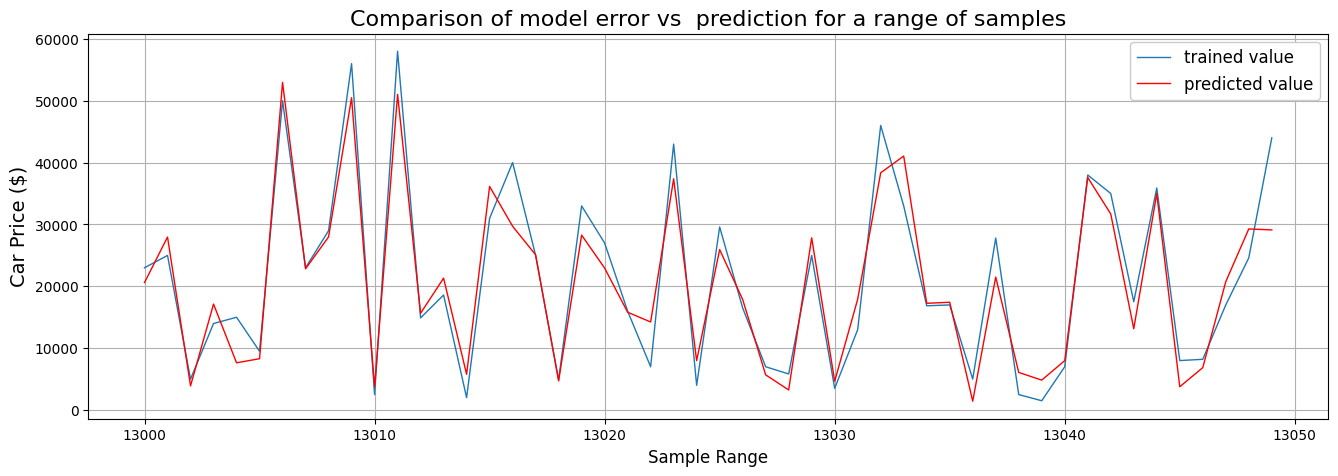

In [161]:
df = ''
df = pd.DataFrame({
    'Training data': y_train,
    'Predictions': m4_train_preds
})
df.reset_index(drop=True, inplace=True)

my_range = df[13000:13050]

plt.figure(figsize=(16,5))
plt.grid()
plt.plot(my_range[['Training data']],label='trained value',linewidth=1)
plt.plot(my_range[['Predictions']],label='predicted value',color='red', linewidth=1)
# plt.plot(result_air.trend,label='trend',color='red',linewidth=3)
# # plt.plot(air_season_and_trend,label='trend + seasonal',color='royalblue',linewidth=3)
# plt.plot(10*result_air.seasonal,label='seasonality',color='green',linewidth=3)
# # plt.plot(y_future,'k',alpha=0.5,linewidth=1)

plt.title('Comparison of model error vs  prediction for a range of samples', fontsize=16)
plt.legend(loc='upper right',fontsize=12,framealpha=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylabel('Car Price ($)',fontsize=14)
plt.xlabel('Sample Range',fontsize=12)
# plt.title('Airline Passengers through time')
plt.show()



In [50]:
poly_features = ''
X_train_poly = ''
X_test_poly = ''
columns = ''
train_df = ''
test_df = ''

X_train_cp = X_train
X_test_cp = X_test

X_train_cp['Log_Value_Year'] = X_train['year'].apply(lambda x: np.log1p(x))
X_train_cp['Log_Value_odometer'] = X_train['odometer'].apply(lambda x: np.log1p(x))

X_test_cp['Log_Value_Year'] = X_test['year'].apply(lambda x: np.log1p(x))
X_test_cp['Log_Value_odometer'] = X_test['odometer'].apply(lambda x: np.log1p(x))

poly_features = PolynomialFeatures(degree = 3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_cp[['Log_Value_Year', 'Log_Value_odometer', 'Encoded_condition', 'Encoded_title_status', 'type_SUV', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'drive_unknown']])

X_test_poly = poly_features.fit_transform(X_test_cp[['Log_Value_Year', 'Log_Value_odometer', 'Encoded_condition', 'Encoded_title_status', 'type_SUV', 'type_bus', 'type_convertible',
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'drive_unknown']])

columns = poly_features.get_feature_names_out()
train_df = pd.DataFrame(X_train_poly, columns=columns)
test_df = pd.DataFrame(X_test_poly, columns = columns)


#### Using `SequentialFeatureSelector`

Now, using polynomial features we will use the sequential feature selector transformer to take a high dimensional dataset and obtain a lower dimensional dataset.  This will tell me which features are more important than others.  After that i will run the dataset with less columns under the models that i was unable to run earlier to see if that makes a difference improving the predictions.   

I will use this technique to select, 3, 5 & 10 features to observe the columns (features that are more important).  Note that this algorithm is known to be 'fast' but not guaranteed to be optimal.

In [51]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

best_features_df.head()

,drive_fwd,Log_Value_Year^3,Log_Value_Year^2 Log_Value_odometer,Log_Value_odometer^3,Encoded_title_status^2 drive_4wd
0,0.0,439.824662,714.379147,1884.634560,9.0
1,1.0,439.738240,707.856749,1834.204117,0.0
2,0.0,439.651786,700.610301,1779.147157,36.0
3,0.0,439.478784,651.116593,1429.224531,0.0
4,0.0,439.997411,666.692330,1530.650843,36.0


In [52]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

best_features_df.head()

,Log_Value_Year^2 Log_Value_odometer,Log_Value_odometer^3,Encoded_title_status^2 drive_4wd
0,714.379147,1884.634560,9.0
1,707.856749,1834.204117,0.0
2,700.610301,1779.147157,36.0
3,651.116593,1429.224531,0.0
4,666.692330,1530.650843,36.0


In [53]:
selector = SequentialFeatureSelector(Ridge(alpha=1.0), n_features_to_select=5)
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

best_features_df.head()

,drive_fwd,Log_Value_Year^3,Log_Value_Year^2 Log_Value_odometer,Log_Value_odometer^3,Encoded_title_status^2 drive_4wd
0,0.0,439.824662,714.379147,1884.634560,9.0
1,1.0,439.738240,707.856749,1834.204117,0.0
2,0.0,439.651786,700.610301,1779.147157,36.0
3,0.0,439.478784,651.116593,1429.224531,0.0
4,0.0,439.997411,666.692330,1530.650843,36.0


In [54]:
selector = SequentialFeatureSelector(Ridge(alpha=1000), n_features_to_select=10)
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

best_features_df.head()

,Log_Value_Year drive_fwd,Log_Value_Year^3,Log_Value_Year^2 Log_Value_odometer,Log_Value_odometer^3,Log_Value_odometer type_SUV drive_4wd,Log_Value_odometer type_sedan drive_4wd,Log_Value_odometer transmission_automatic drive_unknown,Encoded_condition Encoded_title_status drive_4wd,Encoded_title_status^2 drive_4wd,Encoded_title_status type_wagon drive_4wd
0,0.000000,439.824662,714.379147,1884.634560,0.000000,0.0,0.000000,0.0,9.0,0.0
1,7.604396,439.738240,707.856749,1834.204117,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.000000,439.651786,700.610301,1779.147157,0.000000,0.0,0.000000,12.0,36.0,0.0
3,0.000000,439.478784,651.116593,1429.224531,0.000000,0.0,11.264195,0.0,0.0,0.0
4,0.000000,439.997411,666.692330,1530.650843,11.524587,0.0,0.000000,0.0,36.0,0.0


In [59]:
best_10_features = selector.get_feature_names_out()
best_10_features

array(['Log_Value_Year drive_fwd', 'Log_Value_Year^3',
       'Log_Value_Year^2 Log_Value_odometer', 'Log_Value_odometer^3',
       'Log_Value_odometer type_SUV drive_4wd',
       'Log_Value_odometer type_sedan drive_4wd',
       'Log_Value_odometer transmission_automatic drive_unknown',
       'Encoded_condition Encoded_title_status drive_4wd',
       'Encoded_title_status^2 drive_4wd',
       'Encoded_title_status type_wagon drive_4wd'], dtype=object)

#### Conclusion on sequential feature selection

I found that given the combination and subset of data, the most important columns (based on the different SFS n values):

  
| Feature      | n=3 | n=5 | n=10 |
| ------------ | --- | --- | ---- |
| Odometer     | x   | x   | x    |
| Title Status | x   | x   | x    |
| Year         | x   | x   | x    |
| Drive 4WD    | x   | x   | x    |
| Drive FWD    |     | x   | x    |
| Type (Sedan) |     |     | x    |
| Type (SUV)   |     |     | x    |
| Type (Wagon) |     |     | x    |
| Condition    |     |     | x    |
| Trans (auto) |     |     | x    |


It is interesting to see how it expands consistently as you go up in `n`.  One surprise is the `condition` feature that was not present on the lower resolution selections. 

I will use the list from `n=10` as that would be 10 features that we could say are the most important to drive the price of the car, the ones with more weight on the prediction. 

Now going back to the model setup that we were unable to run due to high dimensionality, let's see how it runs now with this limited set

In [78]:
# Model 9: degree 3 polynomial transform with only top 10 columns
 
# List of column names to select
selected_columns = ['odometer', 'Encoded_title_status',  'transmission_automatic', 'type_SUV', 'Encoded_condition', 'year', 'type_wagon', 'drive_4wd', 'drive_fwd'
                   , 'type_sedan']

# Create a new DataFrame with selected columns
X_train_top10 = X_train[selected_columns]
X_test_top10 = X_test[selected_columns]

pipe = Pipeline([('scaler', StandardScaler()),
                ('pfeat', PolynomialFeatures(degree = 3, include_bias=False)),
                ('ridge', Ridge())])

pipe.fit((X_train_top10), y_train)

m9_train_preds = pipe.predict(X_train_top10)
m9_test_preds = pipe.predict(X_test_top10)

m9_train_mae = mean_absolute_error(y_train, m9_train_preds)
m9_test_mae = mean_absolute_error(y_test, m9_test_preds)

print(f'Model 9 Train MAE: {int(m9_train_mae)}')
print(f'Model 9 Test  MAE: {int(m9_test_mae)}\n')

Model 9 Train MAE: 5979
Model 9 Test  MAE: 5972



### Conclusion on models

At this point given the different model alternatives, we come to the conclusion that the model is not going to improve much further given our resources, we attempted the following:

* Linear Regression
* Ridge Regression
* Lasso Regression

All of them with different transformers such as polynomial features, scalers and logarithms.  In teh chart below you can see the results of the models
comparing the mean absolute error for both the training and test datasets.

This can be seen on the chart below



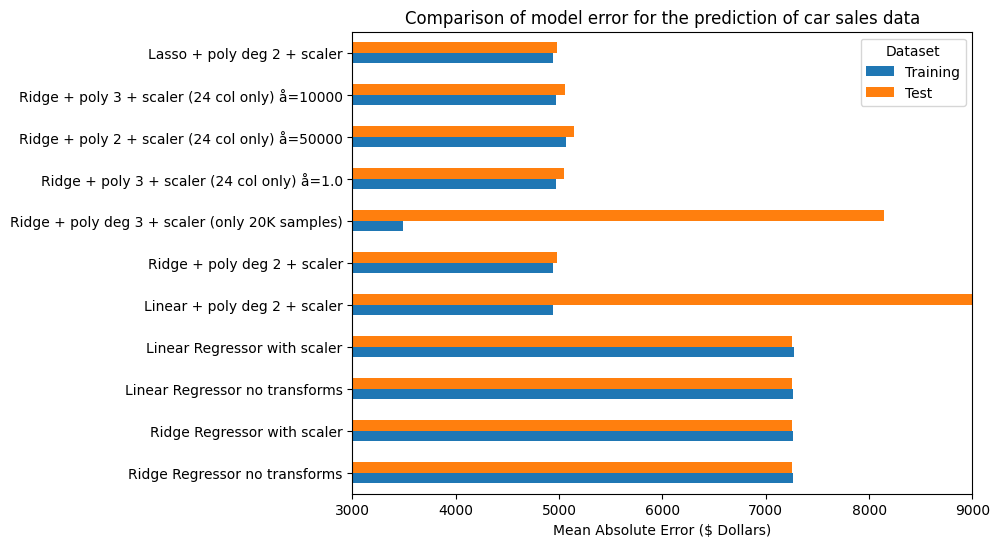

In [94]:
# We are going to plot the different error magnitude for the models used.    
# Note that all the results are obtained in code above, but are hard-coded to avoid re-running lengthy models to see the chart

data = {
    'Model': ['Ridge Regressor no transforms', 
              'Ridge Regressor with scaler',	
              'Linear Regressor no transforms', 
              'Linear Regressor with scaler', 
              'Linear + poly deg 2 + scaler', 
              'Ridge + poly deg 2 + scaler', 
              'Ridge + poly deg 3 + scaler (only 20K samples)',	
              'Ridge + poly 3 + scaler (24 col only) å=1.0', 
              'Ridge + poly 2 + scaler (24 col only) å=50000',	
              'Ridge + poly 3 + scaler (24 col only) å=10000', 
              'Lasso + poly deg 2 + scaler'],
    'Training': [7267,7267,7267,7272,4942,4941,3491,4967,5066,4974,4941],
    'Test': [7250,7249,7249,7255,2277862759,4983,8145,5047,5140,5053,4981]
}


df = pd.DataFrame(data)

# Set the 'Category' column as the index for better plotting
df.set_index('Model', inplace=True)

# Plot a stacked bar chart
ax = df.plot(kind='barh', stacked=False, figsize=(8, 6))

ax.set_xlim(3000, 9000)  # Adjust the limits based on your preference

ax.set_ylabel('')

# Customize the plot
plt.title('Comparison of model error for the prediction of car sales data')
plt.xlabel('Mean Absolute Error ($ Dollars)')
plt.legend(title='Dataset')

# Show the plot
plt.show()

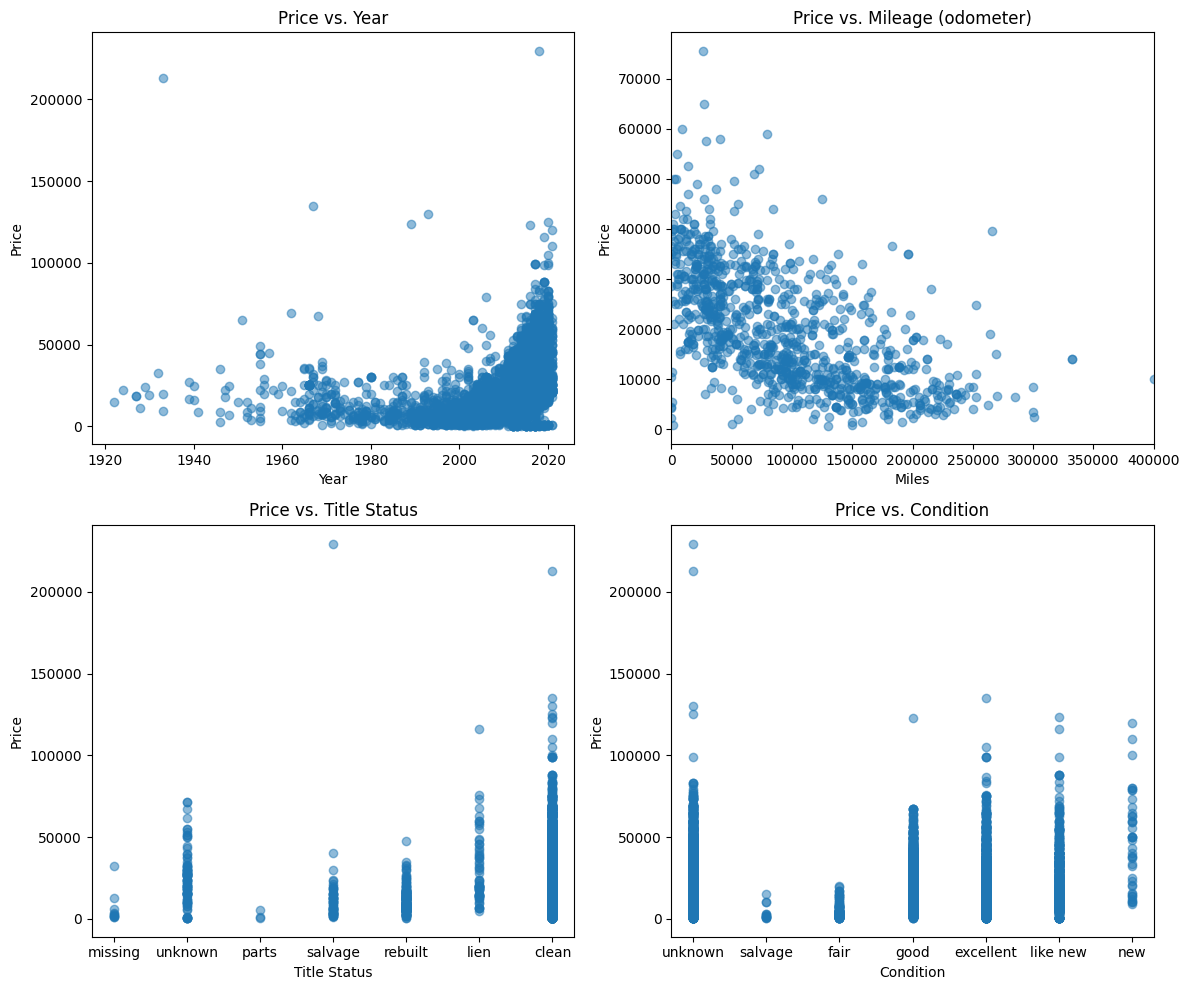

In [171]:
# Now with a subset of the features known to be the major drivers of the prediction, let's plot those vs. price to see how they behave. 


# We will set a 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot Year vs. price
axes[0, 0].scatter(car_data_e['year'][3000:13000], (car_data_e['price'][3000:13000]), alpha=0.5)
axes[0, 0].set_title('Price vs. Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Price')

# Mileage vs. price 
axes[0, 1].scatter((car_data_e['odometer'][3000:4000]), (car_data_e['price'][3000:4000]), alpha=0.5)
axes[0, 1].set_title('Price vs. Mileage (odometer)')
axes[0, 1].set_xlabel('Miles')
axes[0, 1].set_ylabel('Price')
axes[0, 1].set_xlim(0, 400000) 

mapping_table_title = {
    0: 'missing',
    1: 'unknown',
    2: 'parts',
    3: 'salvage',
    4: 'rebuilt',
    5: 'lien',
    6: 'clean',
}

# Title status vs. price (note that we restore the category names from the encoding to make the chart easier to interpret
axes[1, 0].scatter(car_data_e['Encoded_title_status'][3000:13000], (car_data_e['price'][3000:13000]), alpha=0.5)
axes[1, 0].set_title('Price vs. Title Status')
axes[1, 0].set_xlabel('Title Status')
axes[1, 0].set_ylabel('Price')
status_labels = [mapping_table_title.get(label, label) for label in axes[1, 0].get_xticks()]
axes[1, 0].set_xticklabels(status_labels)

mapping_table_condition = {
    0: 'unknown',
    1: 'salvage',
    2: 'fair',
    3: 'good',
    4: 'excellent',
    5: 'like new',
    6: 'new',
}

# Condition vs. price (note that we restore the category names from the encoding to make the chart easier to interpret
axes[1, 1].scatter(car_data_e['Encoded_condition'][3000:13000], (car_data_e['price'][3000:13000]), alpha=0.5)
axes[1, 1].set_title('Price vs. Condition')
axes[1, 1].set_xlabel('Condition')
axes[1, 1].set_ylabel('Price')
status_labels = [mapping_table_condition.get(label, label) for label in axes[1, 0].get_xticks()]
axes[1, 1].set_xticklabels(status_labels)


plt.tight_layout()
plt.show()

#### Some observations on key categories

As seen on the chart above.   We can see how mileage and age are driving factors of the price, newer cars and less mileage cost more in general.    On the bottom charts we look at condition and title status.    This confirms the choice of the ordinal encoder as we see how the category values improve the car price as we go for better title status or better condition.   However there is an interesting caveat around the use of the 'unknown' category in both cases.   The spread is across many pricepoints which helps me draw the conclusion that the 'unknown' category warrantes further investigation by the car purchaser as it could well be a case where the information is simply missing and could fall in any other category.   It may be possible to re-run all the models ignoring entries with that value, but it was a good call given that it helps us draw the conclusion that it should NOT be a factor when defining the car price and instead it should warrant manual investigation to find out which category it should belong. 

## Conclusions
Here are the technical conclusions of the analysis this will be the basis to the customer report which will be written in non-technical language.

#### Modeling and resources
* As seen above i did 11 different combinations of models + transformers, the ridge and lasso model with a polynomial transform of degree 2 yields the lowest error on the prediction, you can also see overfitting in some models as you look at the chart above as the error difference between training and prediction is very high.
    * I used simple cross validation as LOOCV and k-fold were too expensive computationally and got to good conclusions
    * I also tried grid search hyperparameters, did not yield too much of a difference on ridge models
  
* I used Mean absolute error as explained above due to its interpretabily as the main evaluation metric in dollars, so we can compare to an actual vehicle price
* Simplification of the dataset it's critical, thousands for columns becomes very heavy for an efficient analysis on the time required for this activity
* Encoding and applying domain knowledge helps to follow a logic for simplification
* The factors that influence the car price the most are: 
    * Mileage
    * Title Status 
    * Year  
    * Drive type 4wd & fwd
    * Type of vehicle (sedan, SUV & wagon)
    * Condition of the vehicle
    * Automatic transmission

* Observations in compute cost
    * The dataset transformations drive a significant increase in computational resources, i had access to a 10 core 32GB system which was unable to handle 3 degree polynomial transforms for the full dataset, the main limitation is memory (RAM) the more columns the more memory you need.   Polynomial transformations drive an exponential amount of RAM, limiting these will keep the operations under realistic limitations
    * More CPU cores help with overall compute time but don't help where you have a memory shortage
    * The notebook above has commented out cells due to the long time it takes to run some models.
 
    * Overall there is significant error in this model, but given the compute resources and time to tune the model i consider it good enough to provide guidance and direction for tuning the car inventory and provide ideas for localized analysis, for example zooming in regions, manufacturers or car models.

#### Next steps and recommendations
* Data preparation: Remove the 'unknown' entries from the dataset
* Modeling: Get access to more powerful compute resources (more memory mostly) in order to run a degree 3 polynomial transform with more categories
* Develop submodels per state, and per car manufacturer, this will allow to specialize and get specifics into car models from a specific manufacturer and state specific  conditions that may impact the car prices, for example lower states where there is no snow or need for 4wd vehicles.   This could be sold to specific customers that need this data and avoid outliers from other states, or cases where regulatory factors maybe weaved into the data.
* Another recommendation is to use the actual model/analysis as guidance given the range of error, although the objective was NOT to predict car price, but to select cars to put on inventory.
    
